In [1]:
import os
import tensorflow as tf
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt


# # Define the directory containing the images
# #test_image = "BPS-Microscopy/DAPI_MASK_images"
image_dir = "BPS-Microscopy/train"

# Load the metadata from the Excel file
# metadata_path = 'BPS-Microscopy/DAPI_MASK_images/meta_DAPI_MASK.csv'
metadata_path = 'BPS-Microscopy/train/meta.csv'
metadata = pd.read_csv(metadata_path)

# Display the first few rows of the metadata
# print(metadata.head())

# Add the full path to the filenames in the metadata
metadata['filepath'] = metadata['filename'].apply(lambda x: os.path.join(image_dir, x))

# Filter only tif
metadata = metadata[metadata['filename'].str.endswith('.tif')]

# Display the first few rows of the updated metadata
# metadata.head()

2024-11-23 18:28:27.922174: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1732415307.956114  592669 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1732415307.964813  592669 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-23 18:28:27.990253: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
from phasepack.phasecong import phasecong
from skimage.measure import shannon_entropy
from skimage.filters import sobel
from skimage import io
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import pickle

def extract_features(image):
    """
    Extracts features required for BIQA:
    - Mean Phase Congruency (MPC)
    - Entropy of Phase Congruency (EPC)
    - Entropy of the Image (EDIS)
    - Mean Gradient Magnitude of the Image (MGDIS)
    
    Parameters:
    - image: np.array, input grayscale image

    Returns:
    - features: list of feature values [MPC, EPC, EDIS, MGDIS]
    """
    # Compute Phase Congruency
    pc_image, *_ = phasecong(image)
    mpc = np.mean(pc_image)
    epc = shannon_entropy(pc_image)

    # Compute Image Entropy
    edis = shannon_entropy(image)

    # Compute Mean Gradient Magnitude
    gradient_image = sobel(image)
    mgdis = np.mean(gradient_image)

    return [mpc, epc, edis, mgdis]

def prepare_feature_dataset(metadata):
    """
    Extract features and labels for a given dataset.
    """
    features = []
    labels = []
    for _, row in metadata.iterrows():
        image_path = row['filepath']  # Replace with the correct column name for image paths
        try:
            image = io.imread(image_path, as_gray=True)  # Load the image
            feature = extract_features(image)  # Extract features
            features.append(feature)
            labels.append(row['dose_Gy'])  # Replace 'dose' with your target column name
        except Exception as e:
            print(f"Error processing image {image_path}: {e}")
    return np.array(features), np.array(labels)


def load_or_prepare_features(metadata, hr_post_exposure, particle_type):
    filtered_metadata = metadata[
        (metadata['hr_post_exposure'] == hr_post_exposure) &
        (metadata['particle_type'] == particle_type)
    ]
    processed_dir = "processed_features"

    # Define filenames dynamically based on filtering criteria
    train_path = os.path.join(processed_dir, f"train_hr{hr_post_exposure}_particle{particle_type}.pkl")
    val_path = os.path.join(processed_dir, f"val_hr{hr_post_exposure}_particle{particle_type}.pkl")
    test_path = os.path.join(processed_dir, f"test_hr{hr_post_exposure}_particle{particle_type}.pkl")

    if os.path.exists(train_path) and os.path.exists(val_path) and os.path.exists(test_path):
        print("Loading processed datasets and metadata...")
        with open(train_path, "rb") as f:
            X_train, y_train, train_metadata = pickle.load(f)
        with open(val_path, "rb") as f:
            X_val, y_val, val_metadata = pickle.load(f)
        with open(test_path, "rb") as f:
            X_test, y_test, test_metadata = pickle.load(f)
    else:
        print("Processed datasets not found. Calculating features...")

        # Shuffle and split metadata
        shuffled_metadata = filtered_metadata.sample(frac=1, random_state=42).reset_index(drop=True)
        train_size = int(len(shuffled_metadata) * 0.7)
        val_size = int(len(shuffled_metadata) * 0.2)

        train_metadata = shuffled_metadata[:train_size]
        val_metadata = shuffled_metadata[train_size:train_size + val_size]
        test_metadata = shuffled_metadata[train_size + val_size:]

        # Extract features and labels
        X_train, y_train = prepare_feature_dataset(train_metadata)
        X_val, y_val = prepare_feature_dataset(val_metadata)
        X_test, y_test = prepare_feature_dataset(test_metadata)

        # Normalize features
        scaler = MinMaxScaler()
        X_train = scaler.fit_transform(X_train)
        X_val = scaler.transform(X_val)
        X_test = scaler.transform(X_test)

        # Save datasets with metadata
        os.makedirs(processed_dir, exist_ok=True)
        with open(train_path, "wb") as f:
            pickle.dump((X_train, y_train, train_metadata), f)
        with open(val_path, "wb") as f:
            pickle.dump((X_val, y_val, val_metadata), f)
        with open(test_path, "wb") as f:
            pickle.dump((X_test, y_test, test_metadata), f)

    return X_train, y_train, X_val, y_val, X_test, y_test, train_metadata, val_metadata, test_metadata


# Define filtering criteria
hr_post_exposure = 4
particle_type = 'X-ray'

# Pass criteria explicitly to the function
X_train, y_train, X_val, y_val, X_test, y_test, train_metadata, val_metadata, test_metadata = load_or_prepare_features(
    metadata, hr_post_exposure, particle_type
)

print(f"Filtering Criteria - hr_post_exposure: {hr_post_exposure}, particle_type: {particle_type}")
print(f"Train size: {len(X_train)}, Validation size: {len(X_val)}, Test size: {len(X_test)}")


Loading processed datasets and metadata...
Filtering Criteria - hr_post_exposure: 4, particle_type: X-ray
Train size: 9785, Validation size: 2795, Test size: 1399


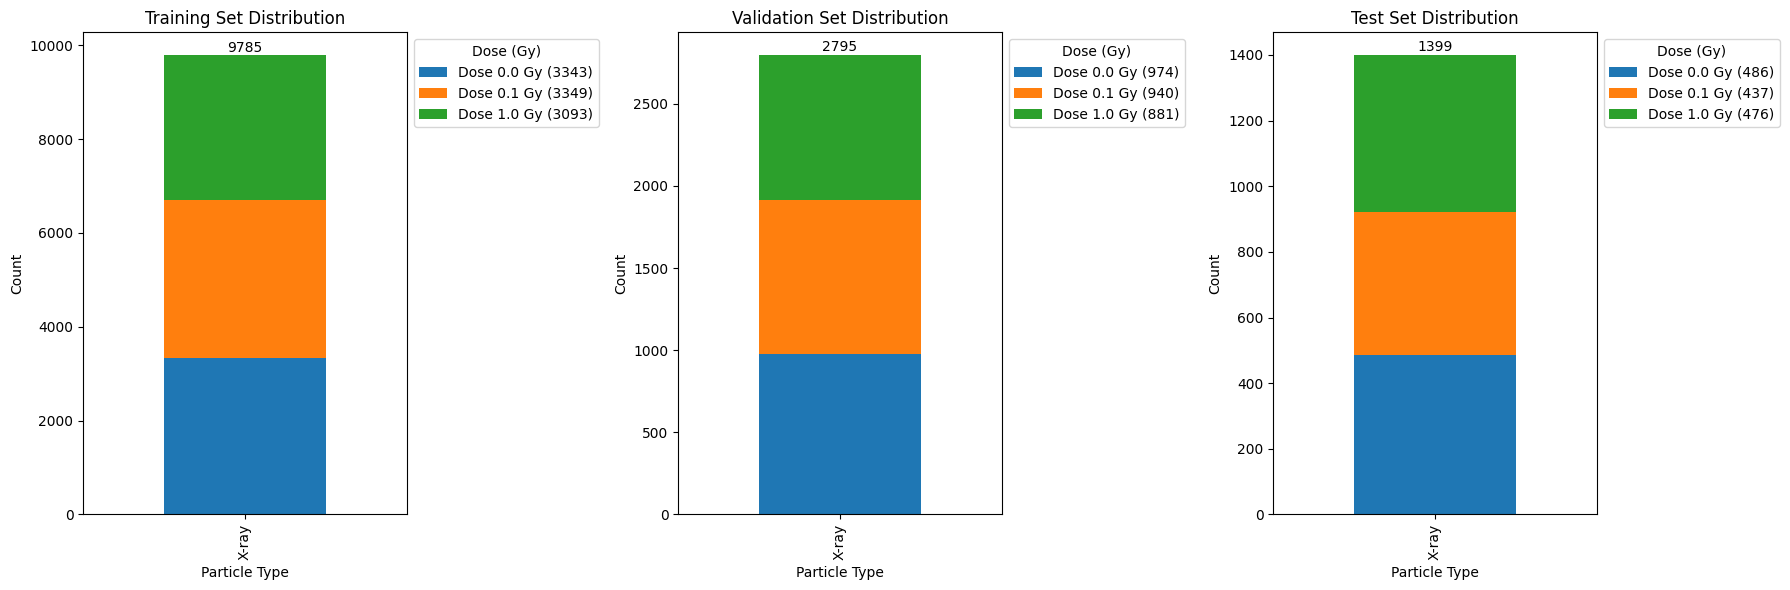

In [3]:
# Check set split

# Function to add total count annotations for each group
def annotate_group_totals(ax, data):
    for i, patch in enumerate(ax.patches):
        if i % len(data.columns) == 0:  # Add annotation only for the first bar of each group
            x = patch.get_x() + patch.get_width() / 2
            total = data.iloc[i // len(data.columns)].sum()
            ax.annotate(f'{int(total)}', (x, total + 5), ha='center', va='bottom', fontsize=10, color='black')

# Function to create legend labels with counts
def create_legend_labels(data):
    labels = []
    for dose in data.columns:
        count = data[dose].sum()
        labels.append(f"Dose {dose} Gy ({int(count)})")
    return labels

# Plot all sets: training, validation, and test
plt.figure(figsize=(18, 6))

# Training set plot
plt.subplot(1, 3, 1)
train_counts = train_metadata.groupby(['particle_type', 'dose_Gy']).size().unstack().fillna(0)
train_ax = train_counts.plot(kind='bar', stacked=True, ax=plt.gca(), legend=False)
annotate_group_totals(train_ax, train_counts)
plt.title('Training Set Distribution')
plt.xlabel('Particle Type')
plt.ylabel('Count')

# Add legend with counts for training set
train_labels = create_legend_labels(train_counts)
plt.legend(train_labels, title="Dose (Gy)", bbox_to_anchor=(1.0, 1.0), loc='upper left')

# Validation set plot
plt.subplot(1, 3, 2)
val_counts = val_metadata.groupby(['particle_type', 'dose_Gy']).size().unstack().fillna(0)
val_ax = val_counts.plot(kind='bar', stacked=True, ax=plt.gca(), legend=False)
annotate_group_totals(val_ax, val_counts)
plt.title('Validation Set Distribution')
plt.xlabel('Particle Type')
plt.ylabel('Count')

# Add legend with counts for validation set
val_labels = create_legend_labels(val_counts)
plt.legend(val_labels, title="Dose (Gy)", bbox_to_anchor=(1.0, 1.0), loc='upper left')

# Test set plot
plt.subplot(1, 3, 3)
test_counts = test_metadata.groupby(['particle_type', 'dose_Gy']).size().unstack().fillna(0)
test_ax = test_counts.plot(kind='bar', stacked=True, ax=plt.gca(), legend=False)
annotate_group_totals(test_ax, test_counts)
plt.title('Test Set Distribution')
plt.xlabel('Particle Type')
plt.ylabel('Count')

# Add legend with counts for test set
test_labels = create_legend_labels(test_counts)
plt.legend(test_labels, title="Dose (Gy)", bbox_to_anchor=(1.0, 1.0), loc='upper left')

# Adjust layout
plt.tight_layout()
plt.show()


In [4]:
# Import required libraries
import wandb
from wandb.integration.keras import WandbMetricsLogger, WandbModelCheckpoint
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import r2_score, mean_absolute_error

# Add Sweep Configuration
sweep_config = {
    'method': 'grid',  # Options: 'grid', 'random', 'bayes'
    'metric': {
        'name': 'val_mae',  # Metric to optimize
        'goal': 'minimize'
    },
    'parameters': {
        'learning_rate': {
            'values': [0.001, 0.005, 0.01]
        },
        'batch_size': {
            'values': [16, 32, 64]
        },
        'epochs': {
            'values': [5, 10, 20]
        },
        'input_dim': {
            'values': [4]  # Keep this static, as features are fixed
        }
    }
}

# Define GRNN-like network using Keras
def grnn(input_dim, learning_rate):
    """
    Build a GRNN-like network using Keras.

    Parameters:
    - input_dim: Number of input features
    - learning_rate: Learning rate for the optimizer

    Returns:
    - Compiled Keras model
    """
    inputs = layers.Input(shape=(input_dim,))
    pattern_layer = layers.Dense(64, activation='relu')(inputs)
    summation_layer = layers.Dense(32, activation='relu')(pattern_layer)
    outputs = layers.Dense(1, activation='linear')(summation_layer)
    model = models.Model(inputs, outputs)
    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss='mean_squared_error',
        metrics=['mae']
    )
    return model

def train():
    # Initialize wandb for this sweep run
    with wandb.init() as run:
        config = run.config

        # Build and compile the model dynamically
        model = grnn(config.input_dim, config.learning_rate)

        # Train the model
        history = model.fit(
            X_train, y_train,
            validation_data=(X_val, y_val),
            epochs=config.epochs,
            batch_size=config.batch_size,
            verbose=2,
            callbacks=[
                WandbMetricsLogger(log_freq="epoch"),
                WandbModelCheckpoint(filepath="model-checkpoints/sweep_model.epoch{epoch:02d}.keras")
            ]
        )

        # Log training and validation metrics for each epoch
        for epoch in range(config.epochs):
            wandb.log({
                "epoch": epoch,
                "train_loss": history.history['loss'][epoch],
                "val_loss": history.history['val_loss'][epoch],
                "val_mae": history.history['val_mae'][epoch],
                "train_mae": history.history['mae'][epoch]
            })

        # Evaluate the model on the test set
        test_loss, test_mae = model.evaluate(X_test, y_test, verbose=0)
        wandb.log({"Test Loss": test_loss, "Test MAE": test_mae})

        # Predict using the model
        predicted_doses = model.predict(X_test).flatten()

        # Calculate R² and log additional metrics
        r2 = r2_score(y_test, predicted_doses)
        absolute_errors = np.abs(y_test - predicted_doses)
        wandb.log({
            "R²": r2,
            "Mean Absolute Error (Test)": np.mean(absolute_errors),
            "Max Absolute Error (Test)": np.max(absolute_errors)
        })

# Initialize the sweep and run the agent
sweep_id = wandb.sweep(sweep_config, project="dose-prediction")
wandb.agent(sweep_id, train, count=10)  # Adjust count as needed


wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


Create sweep with ID: jfi13b1p
Sweep URL: https://wandb.ai/walt_/dose-prediction/sweeps/jfi13b1p


wandb: Agent Starting Run: kgbabpgr with config:
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	input_dim: 4
wandb: 	learning_rate: 0.001
wandb: Currently logged in as: walt_. Use `wandb login --relogin` to force relogin


I0000 00:00:1732415354.574290  592859 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 21358 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:33:00.0, compute capability: 8.6


Epoch 1/5


I0000 00:00:1732415379.475956  592938 service.cc:148] XLA service 0x7f0b40004560 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1732415379.476151  592938 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 3090, Compute Capability 8.6
2024-11-23 18:29:39.512825: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1732415379.634564  592938 cuda_dnn.cc:529] Loaded cuDNN version 90501
I0000 00:00:1732415380.740362  592938 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


612/612 - 7s - 12ms/step - loss: 0.1502 - mae: 0.3249 - val_loss: 0.1407 - val_mae: 0.3207
Epoch 2/5
612/612 - 2s - 3ms/step - loss: 0.1345 - mae: 0.2918 - val_loss: 0.1340 - val_mae: 0.2889
Epoch 3/5
612/612 - 2s - 3ms/step - loss: 0.1318 - mae: 0.2844 - val_loss: 0.1338 - val_mae: 0.2781
Epoch 4/5
612/612 - 2s - 3ms/step - loss: 0.1288 - mae: 0.2784 - val_loss: 0.1296 - val_mae: 0.2769
Epoch 5/5
612/612 - 2s - 3ms/step - loss: 0.1265 - mae: 0.2741 - val_loss: 0.1274 - val_mae: 0.2669
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


Max Absolute Error (Test),▁
Mean Absolute Error (Test),▁
R²,▁
Test Loss,▁
Test MAE,▁
epoch,▁▃▅▆█
epoch/epoch,▁▃▅▆█
epoch/learning_rate,▁▁▁▁▁
epoch/loss,█▃▃▂▁
epoch/mae,█▃▂▂▁
epoch/val_loss,█▄▄▂▁


wandb: Agent Starting Run: glxjfjhy with config:
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	input_dim: 4
wandb: 	learning_rate: 0.005


Epoch 1/5
612/612 - 6s - 9ms/step - loss: 0.1466 - mae: 0.3122 - val_loss: 0.1358 - val_mae: 0.3015
Epoch 2/5
612/612 - 2s - 3ms/step - loss: 0.1360 - mae: 0.2895 - val_loss: 0.1358 - val_mae: 0.2986
Epoch 3/5
612/612 - 3s - 5ms/step - loss: 0.1312 - mae: 0.2797 - val_loss: 0.1338 - val_mae: 0.2888
Epoch 4/5
612/612 - 3s - 5ms/step - loss: 0.1277 - mae: 0.2711 - val_loss: 0.1246 - val_mae: 0.2785
Epoch 5/5
612/612 - 3s - 4ms/step - loss: 0.1243 - mae: 0.2656 - val_loss: 0.1236 - val_mae: 0.2473
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


Max Absolute Error (Test),▁
Mean Absolute Error (Test),▁
R²,▁
Test Loss,▁
Test MAE,▁
epoch,▁▃▅▆█
epoch/epoch,▁▃▅▆█
epoch/learning_rate,▁▁▁▁▁
epoch/loss,█▅▃▂▁
epoch/mae,█▅▃▂▁
epoch/val_loss,██▇▂▁


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 4vn33s5w with config:
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	input_dim: 4
wandb: 	learning_rate: 0.01


Epoch 1/5
612/612 - 3s - 5ms/step - loss: 0.1437 - mae: 0.3034 - val_loss: 0.1395 - val_mae: 0.3136
Epoch 2/5
612/612 - 1s - 2ms/step - loss: 0.1373 - mae: 0.2898 - val_loss: 0.1340 - val_mae: 0.2726
Epoch 3/5
612/612 - 1s - 2ms/step - loss: 0.1335 - mae: 0.2805 - val_loss: 0.1366 - val_mae: 0.2945
Epoch 4/5
612/612 - 1s - 2ms/step - loss: 0.1307 - mae: 0.2758 - val_loss: 0.1290 - val_mae: 0.2503
Epoch 5/5
612/612 - 1s - 2ms/step - loss: 0.1269 - mae: 0.2674 - val_loss: 0.1271 - val_mae: 0.2939
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Max Absolute Error (Test),▁
Mean Absolute Error (Test),▁
R²,▁
Test Loss,▁
Test MAE,▁
epoch,▁▃▅▆█
epoch/epoch,▁▃▅▆█
epoch/learning_rate,▁▁▁▁▁
epoch/loss,█▅▄▃▁
epoch/mae,█▅▄▃▁
epoch/val_loss,█▅▆▂▁


wandb: Agent Starting Run: 76nhp41k with config:
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	input_dim: 4
wandb: 	learning_rate: 0.001


Epoch 1/10
612/612 - 3s - 4ms/step - loss: 0.1434 - mae: 0.3124 - val_loss: 0.1376 - val_mae: 0.2868
Epoch 2/10
612/612 - 1s - 2ms/step - loss: 0.1343 - mae: 0.2902 - val_loss: 0.1346 - val_mae: 0.2897
Epoch 3/10
612/612 - 1s - 2ms/step - loss: 0.1318 - mae: 0.2843 - val_loss: 0.1317 - val_mae: 0.2858
Epoch 4/10
612/612 - 1s - 2ms/step - loss: 0.1286 - mae: 0.2788 - val_loss: 0.1289 - val_mae: 0.2843
Epoch 5/10
612/612 - 1s - 2ms/step - loss: 0.1272 - mae: 0.2759 - val_loss: 0.1298 - val_mae: 0.2674
Epoch 6/10
612/612 - 1s - 2ms/step - loss: 0.1245 - mae: 0.2706 - val_loss: 0.1242 - val_mae: 0.2754
Epoch 7/10
612/612 - 1s - 2ms/step - loss: 0.1232 - mae: 0.2684 - val_loss: 0.1237 - val_mae: 0.2530
Epoch 8/10
612/612 - 1s - 2ms/step - loss: 0.1203 - mae: 0.2627 - val_loss: 0.1210 - val_mae: 0.2607
Epoch 9/10
612/612 - 2s - 3ms/step - loss: 0.1181 - mae: 0.2595 - val_loss: 0.1184 - val_mae: 0.2777
Epoch 10/10
612/612 - 2s - 3ms/step - loss: 0.1163 - mae: 0.2576 - val_loss: 0.1144 - val_m

Max Absolute Error (Test),▁
Mean Absolute Error (Test),▁
R²,▁
Test Loss,▁
Test MAE,▁
epoch,▁▂▃▃▄▅▆▆▇█
epoch/epoch,▁▂▃▃▄▅▆▆▇█
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▆▅▄▄▃▃▂▁▁
epoch/mae,█▅▄▄▃▃▂▂▁▁
epoch/val_loss,█▇▆▅▆▄▄▃▂▁


wandb: Agent Starting Run: d8d39882 with config:
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	input_dim: 4
wandb: 	learning_rate: 0.005


Epoch 1/10
612/612 - 3s - 4ms/step - loss: 0.1459 - mae: 0.3095 - val_loss: 0.1422 - val_mae: 0.2748
Epoch 2/10
612/612 - 1s - 2ms/step - loss: 0.1353 - mae: 0.2858 - val_loss: 0.1326 - val_mae: 0.2915
Epoch 3/10
612/612 - 1s - 2ms/step - loss: 0.1326 - mae: 0.2819 - val_loss: 0.1304 - val_mae: 0.2762
Epoch 4/10
612/612 - 1s - 2ms/step - loss: 0.1306 - mae: 0.2771 - val_loss: 0.1414 - val_mae: 0.2550
Epoch 5/10
612/612 - 1s - 2ms/step - loss: 0.1292 - mae: 0.2747 - val_loss: 0.1265 - val_mae: 0.2668
Epoch 6/10
612/612 - 1s - 2ms/step - loss: 0.1250 - mae: 0.2681 - val_loss: 0.1226 - val_mae: 0.2543
Epoch 7/10
612/612 - 1s - 2ms/step - loss: 0.1304 - mae: 0.2721 - val_loss: 0.1305 - val_mae: 0.2512
Epoch 8/10
612/612 - 1s - 2ms/step - loss: 0.1230 - mae: 0.2633 - val_loss: 0.1194 - val_mae: 0.2386
Epoch 9/10
612/612 - 1s - 2ms/step - loss: 0.1203 - mae: 0.2572 - val_loss: 0.1240 - val_mae: 0.2705
Epoch 10/10
612/612 - 1s - 2ms/step - loss: 0.1177 - mae: 0.2540 - val_loss: 0.1364 - val_m

Max Absolute Error (Test),▁
Mean Absolute Error (Test),▁
R²,▁
Test Loss,▁
Test MAE,▁
epoch,▁▂▃▃▄▅▆▆▇█
epoch/epoch,▁▂▃▃▄▅▆▆▇█
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▅▅▄▄▃▄▂▂▁
epoch/mae,█▅▅▄▄▃▃▂▁▁
epoch/val_loss,█▅▄█▃▂▄▁▂▆


wandb: Agent Starting Run: df0qtxhx with config:
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	input_dim: 4
wandb: 	learning_rate: 0.01


Epoch 1/10
612/612 - 3s - 4ms/step - loss: 0.1483 - mae: 0.3077 - val_loss: 0.1490 - val_mae: 0.3353
Epoch 2/10
612/612 - 1s - 2ms/step - loss: 0.1353 - mae: 0.2862 - val_loss: 0.1330 - val_mae: 0.2925
Epoch 3/10
612/612 - 1s - 2ms/step - loss: 0.1334 - mae: 0.2810 - val_loss: 0.1288 - val_mae: 0.2866
Epoch 4/10
612/612 - 1s - 2ms/step - loss: 0.1313 - mae: 0.2773 - val_loss: 0.1280 - val_mae: 0.2609
Epoch 5/10
612/612 - 1s - 2ms/step - loss: 0.1266 - mae: 0.2690 - val_loss: 0.1216 - val_mae: 0.2731
Epoch 6/10
612/612 - 1s - 2ms/step - loss: 0.1217 - mae: 0.2597 - val_loss: 0.1276 - val_mae: 0.2882
Epoch 7/10
612/612 - 1s - 2ms/step - loss: 0.1208 - mae: 0.2585 - val_loss: 0.1222 - val_mae: 0.2843
Epoch 8/10
612/612 - 1s - 2ms/step - loss: 0.1162 - mae: 0.2500 - val_loss: 0.1107 - val_mae: 0.2395
Epoch 9/10
612/612 - 1s - 2ms/step - loss: 0.1150 - mae: 0.2461 - val_loss: 0.1117 - val_mae: 0.2483
Epoch 10/10
612/612 - 1s - 2ms/step - loss: 0.1120 - mae: 0.2406 - val_loss: 0.1148 - val_m

Max Absolute Error (Test),▁
Mean Absolute Error (Test),▁
R²,▁
Test Loss,▁
Test MAE,▁
epoch,▁▂▃▃▄▅▆▆▇█
epoch/epoch,▁▂▃▃▄▅▆▆▇█
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▅▅▅▄▃▃▂▂▁
epoch/mae,█▆▅▅▄▃▃▂▂▁
epoch/val_loss,█▅▄▄▃▄▃▁▁▂


wandb: Agent Starting Run: al298hlm with config:
wandb: 	batch_size: 16
wandb: 	epochs: 20
wandb: 	input_dim: 4
wandb: 	learning_rate: 0.001


Epoch 1/20
612/612 - 3s - 5ms/step - loss: 0.1496 - mae: 0.3189 - val_loss: 0.1388 - val_mae: 0.2911
Epoch 2/20
612/612 - 1s - 2ms/step - loss: 0.1351 - mae: 0.2934 - val_loss: 0.1358 - val_mae: 0.3014
Epoch 3/20
612/612 - 1s - 2ms/step - loss: 0.1320 - mae: 0.2867 - val_loss: 0.1328 - val_mae: 0.2948
Epoch 4/20
612/612 - 1s - 2ms/step - loss: 0.1293 - mae: 0.2811 - val_loss: 0.1418 - val_mae: 0.2753
Epoch 5/20
612/612 - 1s - 2ms/step - loss: 0.1278 - mae: 0.2762 - val_loss: 0.1361 - val_mae: 0.2645
Epoch 6/20
612/612 - 1s - 2ms/step - loss: 0.1252 - mae: 0.2730 - val_loss: 0.1266 - val_mae: 0.2835
Epoch 7/20
612/612 - 1s - 2ms/step - loss: 0.1237 - mae: 0.2699 - val_loss: 0.1235 - val_mae: 0.2606
Epoch 8/20
612/612 - 2s - 3ms/step - loss: 0.1217 - mae: 0.2648 - val_loss: 0.1280 - val_mae: 0.2609
Epoch 9/20
612/612 - 3s - 6ms/step - loss: 0.1202 - mae: 0.2639 - val_loss: 0.1213 - val_mae: 0.2525
Epoch 10/20
612/612 - 2s - 3ms/step - loss: 0.1179 - mae: 0.2596 - val_loss: 0.1201 - val_m

Max Absolute Error (Test),▁
Mean Absolute Error (Test),▁
R²,▁
Test Loss,▁
Test MAE,▁
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
epoch/epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▆▅▅▄▄▄▃▃▃▃▂▂▂▂▁▁▁▁▁
epoch/mae,█▆▅▅▄▄▄▃▃▃▃▂▂▂▂▁▁▁▁▁
epoch/val_loss,▇▇▆█▇▅▅▅▄▄▃▃▃▅▂▂▁▁▂▁


wandb: Agent Starting Run: 21oj4t9b with config:
wandb: 	batch_size: 16
wandb: 	epochs: 20
wandb: 	input_dim: 4
wandb: 	learning_rate: 0.005


Epoch 1/20
612/612 - 3s - 4ms/step - loss: 0.1418 - mae: 0.3032 - val_loss: 0.1416 - val_mae: 0.2763
Epoch 2/20
612/612 - 1s - 2ms/step - loss: 0.1334 - mae: 0.2830 - val_loss: 0.1296 - val_mae: 0.2870
Epoch 3/20
612/612 - 1s - 2ms/step - loss: 0.1298 - mae: 0.2759 - val_loss: 0.1310 - val_mae: 0.2846
Epoch 4/20
612/612 - 1s - 2ms/step - loss: 0.1266 - mae: 0.2671 - val_loss: 0.1270 - val_mae: 0.2656
Epoch 5/20
612/612 - 1s - 2ms/step - loss: 0.1231 - mae: 0.2623 - val_loss: 0.1284 - val_mae: 0.2489
Epoch 6/20
612/612 - 1s - 2ms/step - loss: 0.1235 - mae: 0.2617 - val_loss: 0.1254 - val_mae: 0.2556
Epoch 7/20
612/612 - 1s - 2ms/step - loss: 0.1187 - mae: 0.2519 - val_loss: 0.1476 - val_mae: 0.3166
Epoch 8/20
612/612 - 1s - 2ms/step - loss: 0.1163 - mae: 0.2493 - val_loss: 0.1201 - val_mae: 0.2346
Epoch 9/20
612/612 - 1s - 2ms/step - loss: 0.1152 - mae: 0.2461 - val_loss: 0.1200 - val_mae: 0.2328
Epoch 10/20
612/612 - 1s - 2ms/step - loss: 0.1127 - mae: 0.2412 - val_loss: 0.1110 - val_m

Max Absolute Error (Test),▁
Mean Absolute Error (Test),▁
R²,▁
Test Loss,▁
Test MAE,▁
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
epoch/epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▆▆▅▄▄▃▃▃▂▂▂▂▁▂▁▁▁▁▁
epoch/mae,█▆▅▅▄▄▃▃▃▂▂▂▂▁▂▁▁▁▁▁
epoch/val_loss,▇▅▅▅▅▅█▄▄▂▂▆▄▆▁▃▁▁▂▄


wandb: Agent Starting Run: ys4s0e7u with config:
wandb: 	batch_size: 16
wandb: 	epochs: 20
wandb: 	input_dim: 4
wandb: 	learning_rate: 0.01


Epoch 1/20
612/612 - 3s - 5ms/step - loss: 0.1447 - mae: 0.3034 - val_loss: 0.1381 - val_mae: 0.3100
Epoch 2/20
612/612 - 1s - 2ms/step - loss: 0.1357 - mae: 0.2864 - val_loss: 0.1422 - val_mae: 0.2732
Epoch 3/20
612/612 - 1s - 2ms/step - loss: 0.1324 - mae: 0.2790 - val_loss: 0.1278 - val_mae: 0.2698
Epoch 4/20
612/612 - 1s - 2ms/step - loss: 0.1293 - mae: 0.2736 - val_loss: 0.1301 - val_mae: 0.2779
Epoch 5/20
612/612 - 1s - 2ms/step - loss: 0.1241 - mae: 0.2637 - val_loss: 0.1203 - val_mae: 0.2694
Epoch 6/20
612/612 - 1s - 2ms/step - loss: 0.1204 - mae: 0.2566 - val_loss: 0.1163 - val_mae: 0.2438
Epoch 7/20
612/612 - 1s - 2ms/step - loss: 0.1178 - mae: 0.2505 - val_loss: 0.1213 - val_mae: 0.2845
Epoch 8/20
612/612 - 1s - 2ms/step - loss: 0.1185 - mae: 0.2529 - val_loss: 0.1110 - val_mae: 0.2397
Epoch 9/20
612/612 - 1s - 2ms/step - loss: 0.1149 - mae: 0.2455 - val_loss: 0.1119 - val_mae: 0.2388
Epoch 10/20
612/612 - 2s - 2ms/step - loss: 0.1127 - mae: 0.2403 - val_loss: 0.1297 - val_m

Max Absolute Error (Test),▁
Mean Absolute Error (Test),▁
R²,▁
Test Loss,▁
Test MAE,▁
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
epoch/epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▆▆▅▄▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁
epoch/mae,█▆▆▅▄▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁
epoch/val_loss,▇█▅▆▄▃▄▂▃▆▄▂▃▁▄▂▁▁▁▄


wandb: Agent Starting Run: y7qdt8ne with config:
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	input_dim: 4
wandb: 	learning_rate: 0.001


Epoch 1/5
306/306 - 3s - 10ms/step - loss: 0.1448 - mae: 0.3158 - val_loss: 0.1390 - val_mae: 0.2886
Epoch 2/5
306/306 - 1s - 3ms/step - loss: 0.1355 - mae: 0.2933 - val_loss: 0.1351 - val_mae: 0.2875
Epoch 3/5
306/306 - 1s - 2ms/step - loss: 0.1323 - mae: 0.2860 - val_loss: 0.1329 - val_mae: 0.2830
Epoch 4/5
306/306 - 1s - 2ms/step - loss: 0.1302 - mae: 0.2828 - val_loss: 0.1306 - val_mae: 0.2863
Epoch 5/5
306/306 - 1s - 3ms/step - loss: 0.1284 - mae: 0.2785 - val_loss: 0.1295 - val_mae: 0.2804
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


Max Absolute Error (Test),▁
Mean Absolute Error (Test),▁
R²,▁
Test Loss,▁
Test MAE,▁
epoch,▁▃▅▆█
epoch/epoch,▁▃▅▆█
epoch/learning_rate,▁▁▁▁▁
epoch/loss,█▄▃▂▁
epoch/mae,█▄▂▂▁
epoch/val_loss,█▅▄▂▁


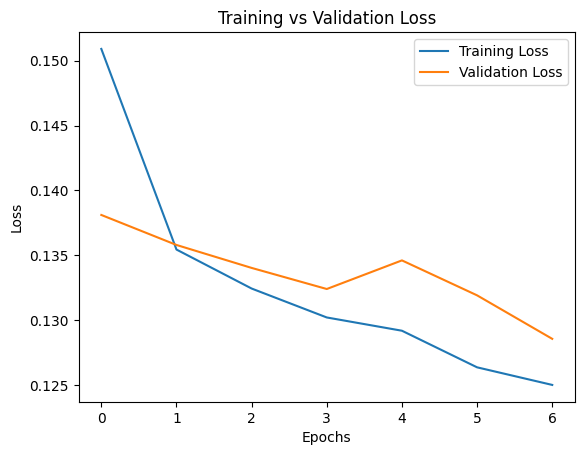

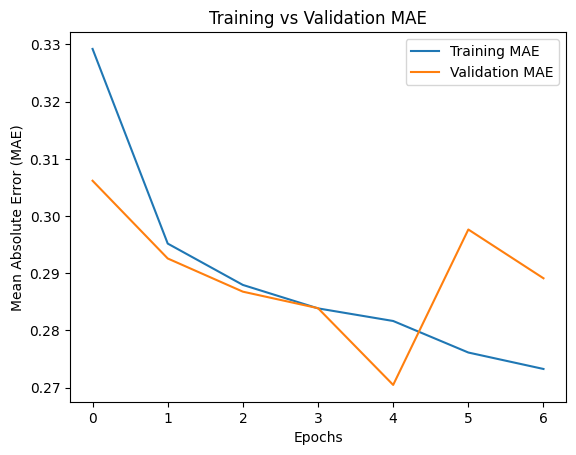

In [5]:
# Plot loss curves
plt.figure()
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training vs Validation Loss')
plt.show()

# Save and log loss plot
plt.savefig("loss_curve.png")
wandb.log({"Loss Curve": wandb.Image("loss_curve.png")})
plt.close()

# Plot MAE curves
plt.figure()
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.xlabel('Epochs')
plt.ylabel('Mean Absolute Error (MAE)')
plt.legend()
plt.title('Training vs Validation MAE')
plt.show()

# Save and log MAE plot
plt.savefig("mae_curve.png")
wandb.log({"MAE Curve": wandb.Image("mae_curve.png")})
plt.close()


In [6]:
# Evaluate and log test metrics
from sklearn.metrics import r2_score, mean_absolute_error

true_doses = test_metadata['dose_Gy'].values
test_results = model.evaluate(X_test, y_test)

# Predict using the model
predicted_doses = model.predict(X_test).flatten()

# Log metrics to W&B
wandb.log({
    "Test Loss": test_results[0],
    "Test MAE": test_results[1],
    "R²": r2_score(true_doses, predicted_doses)
})

# Create a comparison metric (absolute error)
absolute_errors = abs(true_doses - predicted_doses)

# Create a comparison table
comparison_table = pd.DataFrame({
    "Filename": test_metadata["filepath"].values,
    "Actual Dose": true_doses,
    "Predicted Dose": predicted_doses,
    "Absolute Error": absolute_errors
})

# Log sorted comparison table to W&B
sorted_comparison_table = comparison_table.sort_values(by="Absolute Error", ascending=True).reset_index(drop=True)
wandb_table = wandb.Table(dataframe=sorted_comparison_table)
wandb.log({"Comparison Table": wandb_table})

# Log best and worst examples
best_examples = sorted_comparison_table.head(5)
worst_examples = sorted_comparison_table.tail(5)

for _, row in best_examples.iterrows():
    image = cv2.imread(row['Filename'], cv2.IMREAD_GRAYSCALE)
    wandb.log({
        "Best Predictions": wandb.Image(image, caption=f"Actual: {row['Actual Dose']}, Predicted: {row['Predicted Dose']}")
    })

for _, row in worst_examples.iterrows():
    image = cv2.imread(row['Filename'], cv2.IMREAD_GRAYSCALE)
    wandb.log({
        "Worst Predictions": wandb.Image(image, caption=f"Actual: {row['Actual Dose']}, Predicted: {row['Predicted Dose']}")
    })

# Print overall MAE
overall_mae = mean_absolute_error(true_doses, predicted_doses)
print(f"Overall MAE: {overall_mae}")


44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1302 - mae: 0.2933
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Overall MAE: 0.2872229163023011


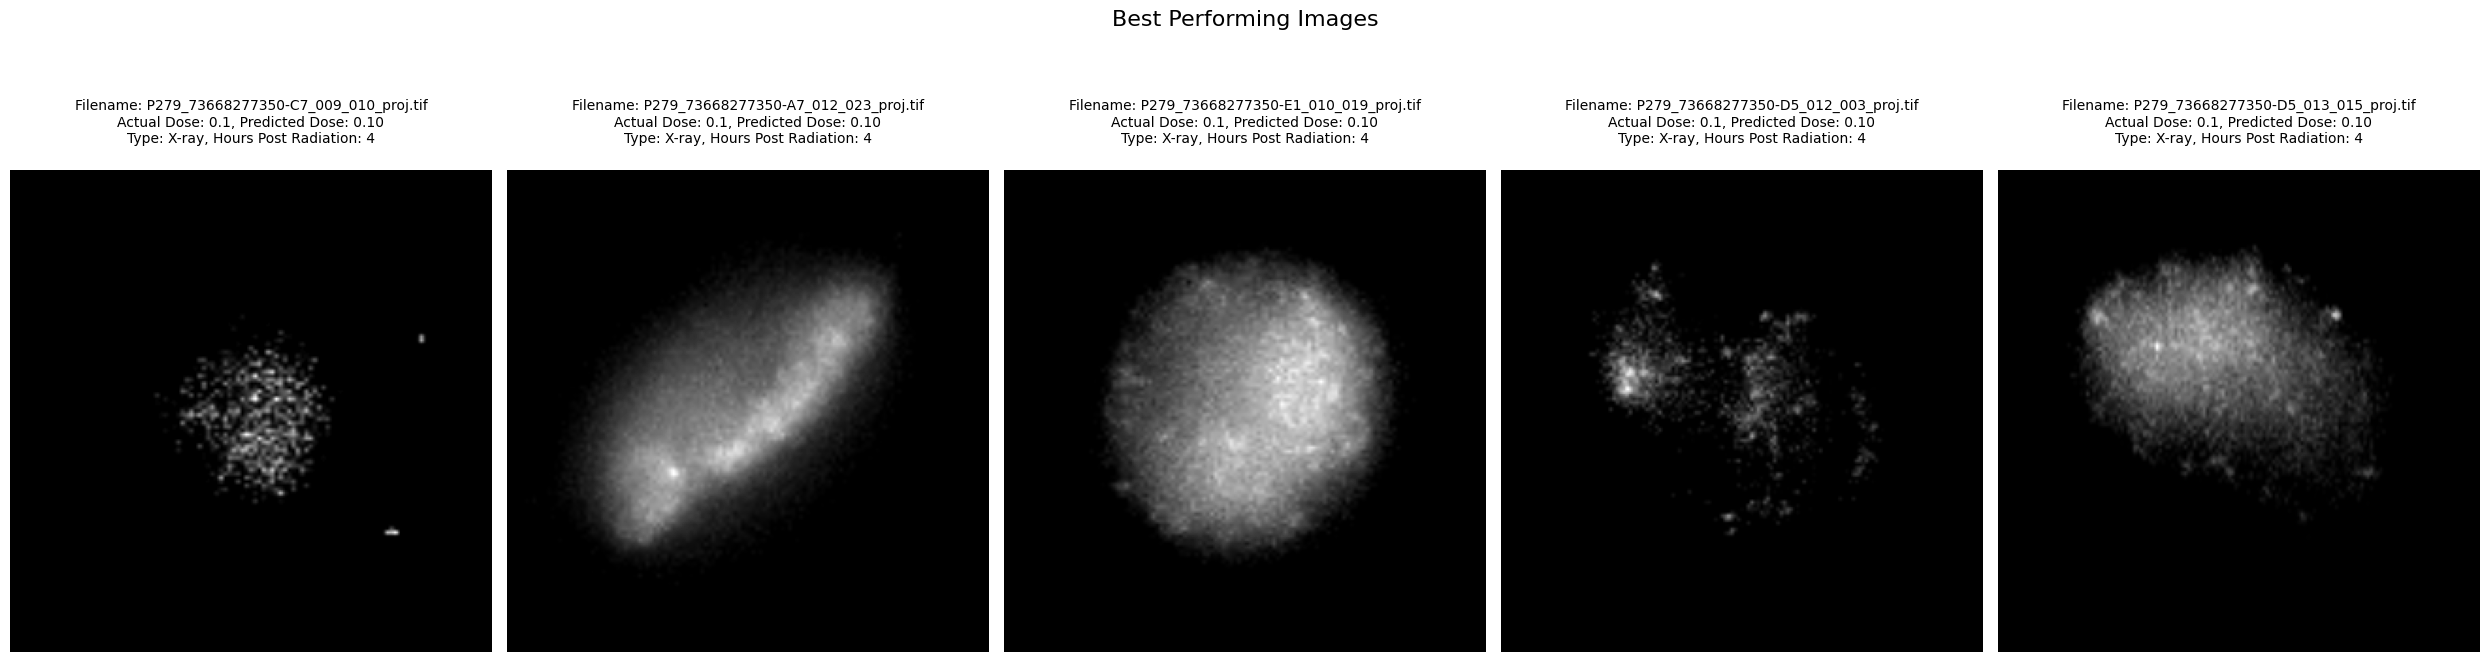

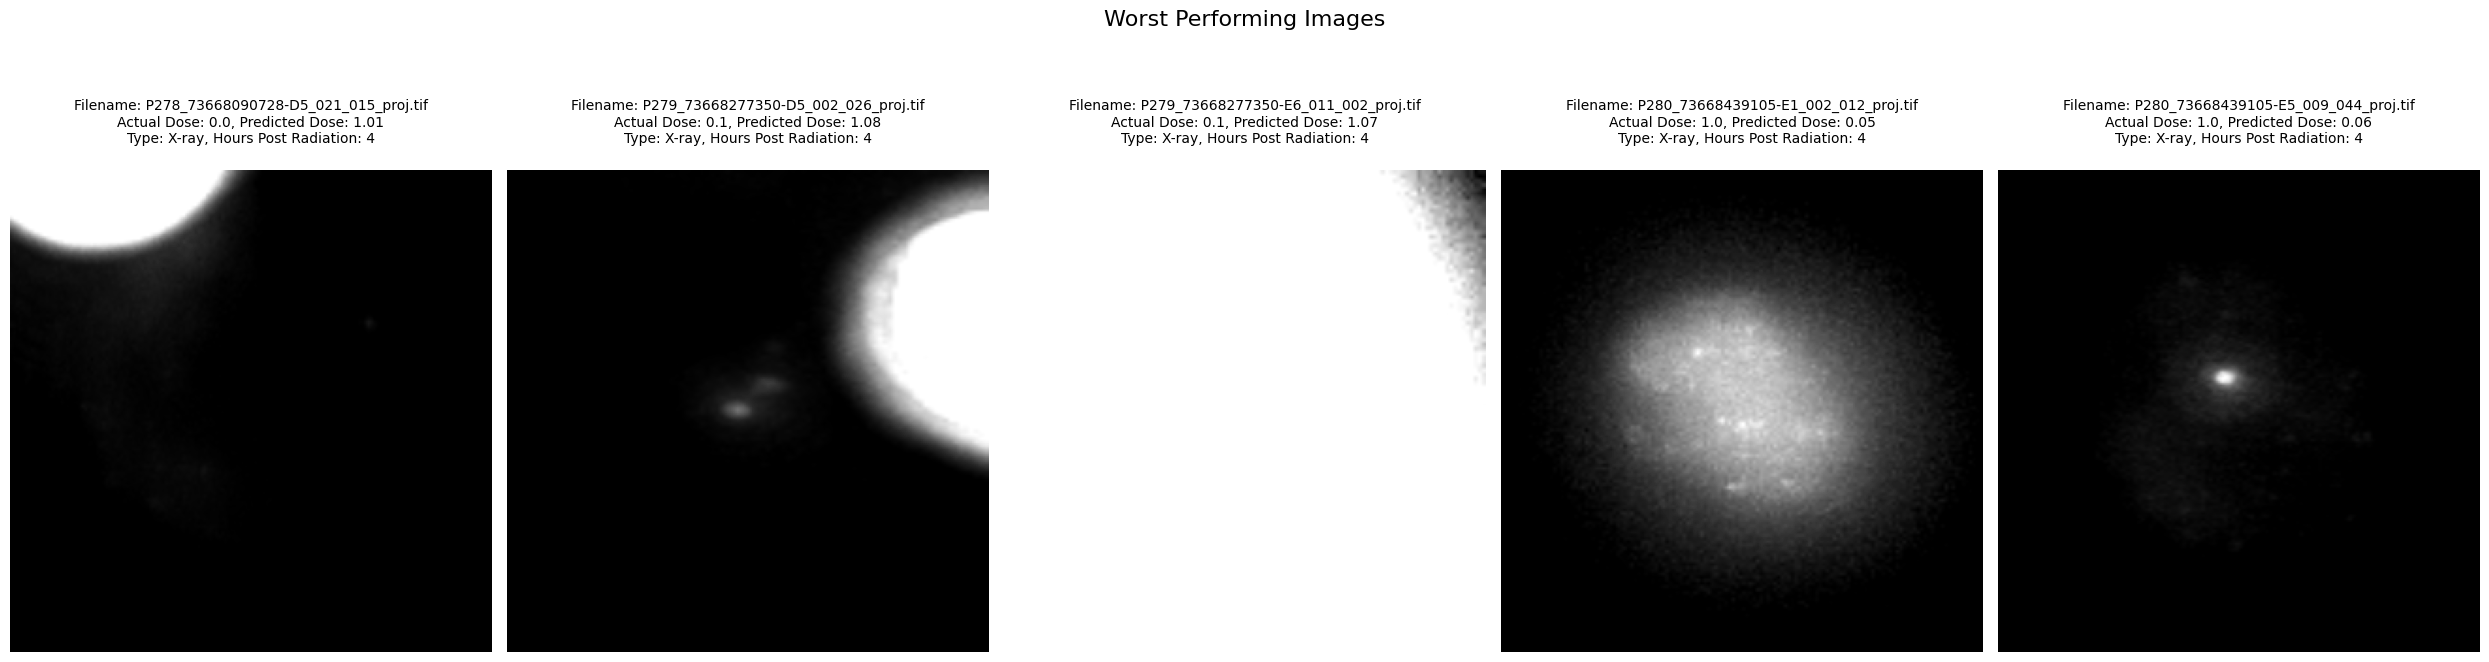

In [7]:
# Sort the data for best and worst performing images
best_performing = comparison_table.sort_values(by="Absolute Error", ascending=True).head(5)
worst_performing = comparison_table.sort_values(by="Absolute Error", ascending=False).head(5)

# Function to preprocess images (clip and normalize)
def preprocess_image(image_path, target_size=(256, 256)):
    image = cv2.imread(image_path, cv2.IMREAD_UNCHANGED)
    if image is None:
        raise ValueError(f"Could not load image: {image_path}")
    
    # Clip image values to [400, 4000]
    image = np.clip(image, 400, 4000)
    
    # Resize the image
    image = cv2.resize(image, target_size)
    
    # Normalize to [0, 1]
    image = (image - 400) / (4000 - 400)
    
    return image

# Function to load and display images with captions
def plot_images(data, title, metadata):
    fig, axes = plt.subplots(1, len(data), figsize=(25, 8))  # Increase figure width and height
    fig.suptitle(title, fontsize=16)

    for idx, (filename, actual, predicted, error) in enumerate(zip(data["Filename"], 
                                                                  data["Actual Dose"], 
                                                                  data["Predicted Dose"], 
                                                                  data["Absolute Error"])):
        # Preprocess image
        image = preprocess_image(filename)
        
        # Plot image
        axes[idx].imshow(image, cmap='gray')
        axes[idx].axis('off')
        
        # Fetch metadata for captions
        metadata_row = metadata[metadata["filepath"] == filename].iloc[0]
        caption = (
            f"Filename: {filename.split('/')[-1]}\n"
            f"Actual Dose: {actual}, Predicted Dose: {predicted:.2f}\n"
            f"Type: {metadata_row['particle_type']}, Hours Post Radiation: {metadata_row['hr_post_exposure']}"
        )
        axes[idx].set_title(caption, fontsize=10, pad=20)  # Add padding to separate the title from the plot

    plt.tight_layout()
    plt.show()


# Plot best-performing images
plot_images(best_performing, "Best Performing Images", test_metadata)

# Plot worst-performing images
plot_images(worst_performing, "Worst Performing Images", test_metadata)


In [8]:
mae_per_dose = {}
for dose in [0.0, 0.1, 1.0]:
    subset = comparison_table[comparison_table['Actual Dose'] == dose]
    mae = subset['Absolute Error'].mean()
    print(f"MAE for Dose {dose}: {mae}")
    mae_per_dose[f"MAE for Dose {dose}"] = mae

# Log all MAE values together
wandb.log(mae_per_dose)


MAE for Dose 0.0: 0.2380539141940298
MAE for Dose 0.1: 0.2433917421562004
MAE for Dose 1.0: 0.37766484513941434


In [9]:
import seaborn as sns

# Create the boxplot
plt.figure(figsize=(8, 6))
sns.boxplot(data=comparison_table, x='Actual Dose', y='Absolute Error')
plt.title("Absolute Error Distribution by Dose")
plt.xlabel("Actual Dose")
plt.ylabel("Absolute Error")

# Save the plot as an image
plt.savefig("absolute_error_boxplot.png")

# Log the plot to W&B
wandb.log({"Absolute Error Boxplot": wandb.Image("absolute_error_boxplot.png")})

# Close the plot to free memory
plt.close()

# Finish the W&B run
wandb.finish()


MAE for Dose 0.0,▁
MAE for Dose 0.1,▁
MAE for Dose 1.0,▁
R²,▁
Test Loss,▁▁
Test MAE,▁▁
epoch/epoch,▁▂▃▅▆▇█
epoch/learning_rate,▁▁▁▁▁▁▁
epoch/loss,█▄▃▂▂▁▁
epoch/mae,█▄▃▂▂▁▁
epoch/val_loss,█▆▅▄▅▃▁


In [ ]:

# Import wandb
import wandb

# Define the sweep configuration
sweep_config = {
    'method': 'grid',  # Options: 'grid', 'random', 'bayes'
    'metric': {
        'name': 'accuracy',  # Metric to optimize
        'goal': 'maximize'   # 'minimize' if you want to minimize
    },
    'parameters': {
        'learning_rate': {
            'values': [0.001, 0.01, 0.1]
        },
        'batch_size': {
            'values': [16, 32, 64]
        },
        'epochs': {
            'values': [10, 20]
        }
    }
}

# Initialize the sweep
sweep_id = wandb.sweep(sweep_config, project='grnn-sweep')

# Define the training function
def train():
    # Initialize wandb run
    with wandb.init() as run:
        config = run.config
        
        # Use config parameters
        learning_rate = config.learning_rate
        batch_size = config.batch_size
        epochs = config.epochs
        
        # Your training logic here
        # Example:
        model = create_model(learning_rate)
        history = model.fit(
            train_data, train_labels,
            epochs=epochs,
            batch_size=batch_size,
            validation_data=(val_data, val_labels)
        )
        
        # Log metrics to wandb
        wandb.log({
            'accuracy': history.history['val_accuracy'][-1],
            'loss': history.history['val_loss'][-1]
        })

# Run the sweep
wandb.agent(sweep_id, train, count=10)  # Adjust 'count' for how many runs you want
